# **Model Training**

### **Load Libraies**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
import joblib
import pickle
import pandas as pd
import copy
import skimage.transform
from torch import topk
from sklearn.metrics import confusion_matrix
from torch.autograd import Variable
from sklearn.metrics import classification_report

In [7]:
import numpy as np # linear algebra
import pickle
#import datetime
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
#from tensorflow.keras.models import Sequential, Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten,Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D,ZeroPadding2D,Conv2D
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
#from tensorflow.keras.utils import utils
from tensorflow.keras.models import model_from_json
# from sklearn.metrics import log_loss
from numpy.random import permutation
import sklearn.metrics as metrics
import keras
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Add, Input, BatchNormalization, Activation
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
import cv2
import matplotlib.pyplot as plt
import glob
from sklearn.preprocessing import LabelEncoder
import os
import zipfile
import torch.nn as nn
%matplotlib inline
# Any results you write to the current directory are saved as output.

In [ ]:
folderpath = '/content/gdrive/MyDrive/Community Help /Abuse Image classification/NumPyArrays/'
modelfolderpath='/content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/'

#### Device

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
device = torch.device('cpu')
device

device(type='cpu')

In [ ]:
!nvidia-smi

Sat Aug 19 13:57:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Load Gray images

In [ ]:
X = np.load(folderpath+'X_gray.npy')
y = np.load(folderpath+'y_gray.npy')

In [ ]:
X.shape, y.shape

In [ ]:
train_imgs = np.load(folderpath+'train_imgs_gray.npy')
train_y = np.load(folderpath+'train_y_gray.npy')
val_imgs = np.load(folderpath+'val_imgs_gray.npy')
val_y = np.load(folderpath+'val_y_gray.npy')

#X = np.load(folderpath+'X_gray.npy')
#y = np.load(folderpath+'y_gray.npy')
X_test = np.load(folderpath+'X_test_gray.npy')
y_test = np.load(folderpath+'y_test_gray.npy')
y_test=np.array(y_test)
val_y=np.array(val_y)
train_imgs.shape , train_y.shape ,val_imgs.shape,val_y.shape,X_test.shape,y_test.shape

In [ ]:
y_test=np.array(y_test)
val_y=np.array(val_y)

In [ ]:
train_imgs.shape , train_y.shape ,val_imgs.shape,val_y.shape,X_test.shape,y_test.shape

((76359, 224, 224, 1),
 (76359,),
 (8485, 224, 224, 1),
 (8485,),
 (21212, 224, 224, 1),
 (21212,))

### Load Color images

In [ ]:
X_color = np.load(folderpath+'X_color.npy')
y_color = np.load(folderpath+'y_color.npy')

In [ ]:
X_color.shape , y_color.shape

((84844, 224, 224, 3), (84844,))

In [ ]:
train_imgs_color = np.load(folderpath+'train_imgs_color.npy')
train_y_color = np.load(folderpath+'train_y_color.npy')

In [ ]:
train_imgs_color = np.load(folderpath+'train_imgs_color.npy')
train_y_color = np.load(folderpath+'train_y_color.npy')

val_imgs_color = np.load(folderpath+'val_imgs_color.npy')
val_y_color = np.load(folderpath+'val_y_color.npy')

X_test_color = np.load(folderpath+'X_test_color.npy')
y_test_color = np.load(folderpath+'y_test_color.npy')
train_imgs_color.shape , val_imgs_color.shape , train_y_color.shape ,  val_y_color.shape

In [ ]:
X_test_color.shape , y_test_color.shape

((21212, 224, 224, 3), (21212,))

In [ ]:
train_imgs_color.shape , val_imgs_color.shape , train_y_color.shape ,  val_y_color.shape

((76359, 224, 224, 3), (8485, 224, 224, 3), (76359,), (8485,))

### Data Preparation

In [ ]:
# data transform to size 224*224
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# data transform to size 64*64
data_transforms2 = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean, std, inplace=False)
        #transforms.Lambda(lambd)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        x = Image.fromarray(x).convert('RGB')
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

    def get_transformed(self):
      self.data2 = []
      for x in self.data:
        x = Image.fromarray(x)
        self.data2.append(self.transform(x))
      return torch.from_numpy(np.array(self.data2)).float()





In [ ]:
# dataset Gray
train_dataset = MyDataset(train_imgs, train_y, data_transforms['train'])
val_dataset = MyDataset(val_imgs,val_y,data_transforms['val'])
test_dataset = MyDataset(X_test,y_test,data_transforms['test'])

train_dataset2 = MyDataset(train_imgs, train_y, data_transforms2['train'])
val_dataset2 = MyDataset(val_imgs,val_y,data_transforms2['val'])
test_dataset2 = MyDataset(X_test,y_test,data_transforms2['test'])


In [ ]:
# dataset Color
train_dataset_color = MyDataset(train_imgs_color, train_y_color, data_transforms['train'])
val_dataset_color = MyDataset(val_imgs_color,val_y_color,data_transforms['val'])
test_dataset_color = MyDataset(X_test_color,y_test_color,data_transforms['test'])

train_dataset2_color = MyDataset(train_imgs_color, train_y_color, data_transforms2['train'])
val_dataset2_color = MyDataset(val_imgs_color,val_y_color,data_transforms2['val'])
test_dataset2_color = MyDataset(X_test_color,y_test_color,data_transforms2['test'])

In [ ]:
torch.manual_seed(42)
# loaders for gray images of size 224*224
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# loaders for gray of size 64*64
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
valid_loader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)




In [ ]:
torch.manual_seed(42)
# loaders for color of size 224*224
train_loader_color = DataLoader(train_dataset_color, batch_size=32, shuffle=True)
valid_loader_color = DataLoader(val_dataset_color, batch_size=32, shuffle=False)
test_loader_color = DataLoader(test_dataset_color, batch_size=32, shuffle=False)

#loaders for color of size 64*64
train_loader2_color = DataLoader(train_dataset2_color, batch_size=32, shuffle=True)
valid_loader2_color = DataLoader(val_dataset2_color, batch_size=32, shuffle=False)
test_loader2_color = DataLoader(test_dataset2_color, batch_size=32, shuffle=False)

In [ ]:
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs, save_path):
    start_time = datetime.now()
    valid_loss_min = np.Inf
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0

        ##########
        #TRAINING
        ##########
        model.train()
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # steps += 1
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)

            loss.backward()
            optimizer.step()

            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # running_loss += loss.item()


        ##########
        #VALIDATION
        ##########
        model.eval()
        for batch_idx, (inputs, labels)  in enumerate(test_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            y_val = model(inputs)
            loss =  criterion(y_val, labels)

            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

       # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        train_losses.append(train_loss)
        val_losses.append(valid_loss)

        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)

    # return trained model
    return model, train_losses, val_losses

### CNN Models

In [ ]:
class CNN_model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=26*26*32, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = x.view(-1, 26*26*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        return self.out(x)

torch.manual_seed(42)

model_2 = CNN_model_2()
model_2.to(device)
model_2

CNN_model_2(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

#### Color images CNN training

In [ ]:
CNN_model_2_224 , train_losses_cnn_2_color, val_losses_cnn_2_color = train_model(
        train_loader=train_loader_color,
        test_loader=valid_loader_color,
        model=model_2,
        criterion=criterion,
        optimizer=optimizer,
        epochs=30 ,save_path = modelfolderpath+'Cnn_model_2-2_img_224_color.pt'
)

Epoch: 0 	Training Loss: 0.782398 	Validation Loss: 0.690068
Saving model..
Epoch: 1 	Training Loss: 0.610581 	Validation Loss: 0.603435
Saving model..


In [ ]:
np.save(folderpath+'train_losses_cnn_2_color.npy', train_losses_cnn_2_color)
np.save(folderpath+'val_losses_cnn_2_color.npy', val_losses_cnn_2_color)

In [ ]:
class CNN_model_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(in_features=6*6*32, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.out = nn.Linear(in_features=256, out_features=10)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        # print(x.size())
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2)
        # print(x.size())
        x = x.view(-1, 6*6*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.2)
        # x = F.sigmoid(x, p=0.2)
        return self.out(x)

torch.manual_seed(42)

model_1 = CNN_model_1()
model_1.to(device)
model_1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [ ]:
CNN_model_1_64 , train_losses_cnn64_1, val_losses_cnn64_1 = train_model(
     train_loader=train_loader2_color,
     test_loader=valid_loader2_color,
     model=model_1,
     criterion=criterion,
     optimizer=optimizer,
     epochs=30, save_path = modelfolderpath+'Cnn_model_1-1_img_64_color.pt'
)


In [ ]:
np.save(folderpath+'train_losses_cnn64_1_color.npy', train_losses_cnn64_1)
np.save(folderpath+'val_losses_cnn64_1_color.npy', val_losses_cnn64_1)

### CNN VGG Training

In [ ]:
def CreateCNNModel(img_rows,img_cols,channels):
  model = Sequential()
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(img_rows,img_cols,channels)))
  model.add(BatchNormalization())
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units = 512,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(units = 128,activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
  return model

#### Gray images VG16

##### Model #1

In [ ]:
modelG=CreateCNNModel(224,224,1)
modelG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                        

In [ ]:
modelfilepath= modelfolderpath+'gray_vg16_new_full.hdf5'
csvfilepath=modelfolderpath+'gray_vg16_new_full.csv'
checkpointgray=ModelCheckpoint(modelfilepath,monitor="val_accuracy",verbose=0,save_best_only=True,mode="max")
csvloggercolor=CSVLogger(csvfilepath)
callbacks_list_gray=[checkpointgray,csvloggercolor]
print("Callbacks created:")
print(callbacks_list_gray[0])
print(callbacks_list_gray[1])
print('')
print("Path to model:", modelfilepath)
print("Path to log:  ", csvfilepath)

Callbacks created:

Path to model: /content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/gray_vg16_new_full.hdf5
Path to log:   /content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/gray_vg16_new_full.csv


In [ ]:
#XG=np.load(folderpath+'img_loads_resize_gray.npy')
#img_labels=np.load(folderpath+'img_labels.npy')

In [ ]:
le=LabelEncoder()
lbls=le.fit_transform(y)
classes=list(le.classes_)
classes=[str(c) for c in classes]
lbls=to_categorical(lbls,num_classes=len(classes))

In [ ]:
train_imgs_vgg , val_imgs_vgg , train_y_vgg , val_y_vgg = train_test_split(X , lbls , test_size=0.1, random_state=9,stratify = lbls)

In [ ]:
train_imgs_vgg.shape , val_imgs_vgg.shape , np.array(train_y_vgg).shape ,  np.array(val_y_vgg).shape

((76359, 224, 224, 1), (8485, 224, 224, 1), (76359, 3), (8485, 3))

In [ ]:
X=""
train_imgs=""
train_y=""
y=""

In [ ]:
#np.save(folderpath+'X_test_vgg',X_test_vgg)
#np.save(folderpath+'y_test_vgg',y_test_vgg)

In [ ]:
resultmodelgray_full=modelG.fit(train_imgs_vgg, train_y_vgg,validation_data=(val_imgs_vgg,val_y_vgg),epochs=20,batch_size=32,shuffle=True,callbacks=callbacks_list_gray)

Epoch 1/20
2387/2387 [==============================] - 665s 273ms/step - loss: 0.8719 - accuracy: 0.6151 - val_loss: 1.5934 - val_accuracy: 0.5184
Epoch 2/20
2387/2387 [==============================] - 636s 266ms/step - loss: 0.7145 - accuracy: 0.6939 - val_loss: 0.8491 - val_accuracy: 0.6402
Epoch 3/20
2387/2387 [==============================] - 631s 264ms/step - loss: 0.6347 - accuracy: 0.7362 - val_loss: 2.4311 - val_accuracy: 0.3237
Epoch 4/20
2387/2387 [==============================] - 634s 266ms/step - loss: 0.5751 - accuracy: 0.7637 - val_loss: 0.6872 - val_accuracy: 0.7102
Epoch 5/20
2387/2387 [==============================] - 635s 266ms/step - loss: 0.5064 - accuracy: 0.7955 - val_loss: 0.5954 - val_accuracy: 0.7517
Epoch 6/20
2387/2387 [==============================] - 629s 264ms/step - loss: 0.4598 - accuracy: 0.8166 - val_loss: 0.7159 - val_accuracy: 0.7031
Epoch 7/20
2387/2387 [==============================] - 628s 263ms/step - loss: 0.4141 - accuracy: 0.8373 - val_

In [ ]:
np.save(modelfolderpath+'train_losses_vg16cnn_gray_new_full.npy', resultmodelgray_full.history['accuracy'])
np.save(modelfolderpath+'val_losses_vg16cnn_gray_new_full.npy', resultmodelgray_full.history['val_accuracy'])

#### Model #2

In [ ]:
modelG=CreateCNNModel(224,224,1)
modelG.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                        

In [ ]:
modelfilepath= modelfolderpath+'gray_vg16_new.hdf5'
csvfilepath=modelfolderpath+'gray_vg16_new.csv'
checkpointgray2=ModelCheckpoint(modelfilepath,monitor="val_accuracy",verbose=0,save_best_only=True,mode="max")
csvloggercolor=CSVLogger(csvfilepath)
callbacks_list_gray2=[checkpointgray2,csvloggercolor]
print("Callbacks created:")
print(callbacks_list_gray2[0])
print(callbacks_list_gray2[1])
print('')
print("Path to model:", modelfilepath)
print("Path to log:  ", csvfilepath)

Callbacks created:

Path to model: /content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/gray_vg16_new.hdf5
Path to log:   /content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/gray_vg16_new.csv


In [ ]:
le=LabelEncoder()
lbls=le.fit_transform(train_y)
classes=list(le.classes_)
classes=[str(c) for c in classes]
lbls=to_categorical(lbls,num_classes=len(classes))

In [ ]:
train_imgs_vgg , val_imgs_vgg , train_y_vgg , val_y_vgg = train_test_split(train_imgs , lbls , test_size=0.2, random_state=12,stratify = lbls)

In [ ]:
train_imgs_vgg.shape , val_imgs_vgg.shape , np.array(train_y_vgg).shape ,  np.array(val_y_vgg).shape

((61087, 224, 224, 1), (15272, 224, 224, 1), (61087, 3), (15272, 3))

In [ ]:
X_vgg=""
train_imgs=""
train_y=""

In [ ]:
resultmodelgray2=modelG.fit(train_imgs_vgg, train_y_vgg,validation_data=(val_imgs_vgg,val_y_vgg),epochs=20,batch_size=32,shuffle=True,callbacks=callbacks_list_gray2)

Epoch 1/20
1909/1909 [==============================] - 527s 270ms/step - loss: 0.8848 - accuracy: 0.6167 - val_loss: 1.1327 - val_accuracy: 0.3698
Epoch 2/20
1909/1909 [==============================] - 518s 271ms/step - loss: 0.6577 - accuracy: 0.7243 - val_loss: 1.0866 - val_accuracy: 0.5989
Epoch 3/20
1909/1909 [==============================] - 515s 270ms/step - loss: 0.5810 - accuracy: 0.7610 - val_loss: 0.8129 - val_accuracy: 0.6337
Epoch 4/20
1909/1909 [==============================] - 505s 265ms/step - loss: 0.5155 - accuracy: 0.7912 - val_loss: 0.9163 - val_accuracy: 0.6101
Epoch 5/20
1909/1909 [==============================] - 513s 269ms/step - loss: 0.4675 - accuracy: 0.8121 - val_loss: 0.8857 - val_accuracy: 0.6425
Epoch 6/20
1909/1909 [==============================] - 512s 268ms/step - loss: 0.4271 - accuracy: 0.8302 - val_loss: 0.7618 - val_accuracy: 0.7302
Epoch 7/20
1909/1909 [==============================] - 505s 265ms/step - loss: 0.3905 - accuracy: 0.8469 - val_

In [ ]:
np.save(modelfolderpath+'train_losses_vg16cnn_gray_new.npy', resultmodelgray2.history['accuracy'])
np.save(modelfolderpath+'val_losses_vg16cnn_gray_new.npy', resultmodelgray2.history['val_accuracy'])

#### Color images VG16

In [ ]:
modelC=CreateCNNModel(224,224,3)
modelC.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 222, 222, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                        

In [ ]:
modelfilepath= modelfolderpath+'color_vg16_new_full.hdf5'
csvfilepath=modelfolderpath+'color_vg16_new_full.csv'
checkpointcolor=ModelCheckpoint(modelfilepath,monitor="val_accuracy",verbose=0,save_best_only=True,mode="max")
csvloggercolor=CSVLogger(csvfilepath)
callbacks_list_color=[checkpointcolor,csvloggercolor]
print("Callbacks created:")
print(callbacks_list_color[0])
print(callbacks_list_color[1])
print('')
print("Path to model:", modelfilepath)
print("Path to log:  ", csvfilepath)

Callbacks created:

Path to model: /content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/color_vg16_new_full.hdf5
Path to log:   /content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/color_vg16_new_full.csv


In [ ]:
#XC=np.load(folderpath+'img_loads_resize_color.npy')
#img_labels=np.load(folderpath+'img_labels.npy')

In [ ]:
le=LabelEncoder()
lbls=le.fit_transform(y_color)
classes=list(le.classes_)
classes=[str(c) for c in classes]
lbls=to_categorical(lbls,num_classes=len(classes))

In [ ]:
train_imgs_vgg_color , val_imgs_vgg_color , train_y_vgg_color , val_y_vgg_color = train_test_split(X_color , lbls , test_size=0.1, random_state=0,stratify = lbls)

In [ ]:
train_imgs_vgg_color.shape , val_imgs_vgg_color.shape , np.array(train_y_vgg_color).shape ,  np.array(val_y_vgg_color).shape

((76359, 224, 224, 3), (8485, 224, 224, 3), (76359, 3), (8485, 3))

In [ ]:
X_color=""
y_color=""

In [ ]:
resultmodelcolor_full=modelC.fit(train_imgs_vgg_color, train_y_vgg_color,validation_data=(val_imgs_vgg_color,val_y_vgg_color),epochs=30,batch_size=5,shuffle=True,callbacks=callbacks_list_color)

In [ ]:
np.save(modelfolderpath+'train_losses_vg16cnn_color_full.npy', resultmodelcolor_full.history['accuracy'])
np.save(modelfolderpath+'val_losses_vg16cnn_color_full.npy', resultmodelcolor_full.history['val_accuracy'])

### Transfer Learning - [ resnet101 ]

In [ ]:
# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=10,save_path=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # valid_loss_min = np.Inf
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        valid_loss = 0.0

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()





                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'val':
              valid_loss = epoch_loss
            else:
              train_loss = epoch_loss


            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        # print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    print("saving model ...")
    torch.save(model.state_dict(), save_path)
    return model , train_losses , val_losses

In [ ]:
dataloaders = {}
dataloaders['train'] = train_loader_color
dataloaders['val'] = valid_loader_color

dataset_sizes = {}
dataset_sizes['train'] = np.shape(train_imgs_color)[0]
dataset_sizes['val'] = np.shape(val_imgs_color)[0]

#### resnet101 [ Stratergy-1 : freezing all layers parameters ]

In [ ]:
pretrained_model_1 = models.resnet101(pretrained=True)

# freezing all parameters
for param in pretrained_model_1.parameters():
    param.requires_grad = False

nb_features = pretrained_model_1.fc.in_features
pretrained_model_1.to(device)

# changing last layer
pretrained_model_1.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
pretrained_model_1.to(device)
pretrained_model_1.fc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:02<00:00, 64.7MB/s]


Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [ ]:
# setting optimizer
pretrained_criterion_1 = nn.CrossEntropyLoss()
params_1 = list(pretrained_model_1.fc.parameters())
pretrained_optimizer_1 = torch.optim.Adam(params_1, lr=0.001)

In [ ]:
# scheduler
# Decay LR by a factor of 0.1 every 7 epochs
from torch.optim import lr_scheduler
exp_lr_scheduler_1 = lr_scheduler.StepLR(pretrained_optimizer_1, step_size=7, gamma=0.1)

In [ ]:
base_model_1 , train_losses_res_1, val_losses_res_1 = train_model(pretrained_model_1, pretrained_criterion_1, pretrained_optimizer_1, exp_lr_scheduler_1, num_epochs=30, save_path = modelfolderpath+'resnet_model_1_loader1_S1.pt' )


Epoch 0/29
----------
Iterating through data...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.5601 Acc: 0.7743
Iterating through data...
val Loss: 0.4730 Acc: 0.8041
Epoch 1/29
----------
Iterating through data...
train Loss: 0.5013 Acc: 0.7993
Iterating through data...
val Loss: 0.4265 Acc: 0.8276
Epoch 2/29
----------
Iterating through data...
train Loss: 0.4818 Acc: 0.8076
Iterating through data...
val Loss: 0.4154 Acc: 0.8325
Epoch 3/29
----------
Iterating through data...
train Loss: 0.4734 Acc: 0.8105
Iterating through data...
val Loss: 0.4032 Acc: 0.8418
Epoch 4/29
----------
Iterating through data...
train Loss: 0.4615 Acc: 0.8157
Iterating through data...
val Loss: 0.4048 Acc: 0.8354
Epoch 5/29
----------
Iterating through data...
train Loss: 0.4589 Acc: 0.8181
Iterating through data...
val Loss: 0.4061 Acc: 0.8458
Epoch 6/29
----------
Iterating through data...
train Loss: 0.4137 Acc: 0.8365
Iterating through data...
val Loss: 0.3810 Acc: 0.8508
Epoch 7/29
----------
Iterating through data...
train Loss: 0.4143 Acc: 0.8367
Iterating through data...
val L

In [ ]:
np.save(modelfolderpath+'train_losses_res_1_loader1.npy', train_losses_res_1)
np.save(modelfolderpath+'val_losses_res_1_loader1.npy', val_losses_res_1)

#### Resnet101 [ Stratergy-2 : frezing previous layers and training only last

---

few ]

In [ ]:
pretrained_model_2 = models.resnet101(pretrained=True)
# pretrained_model_2 = models.vgg16(pretrained=True)

for param in pretrained_model_2.parameters():
    param.requires_grad = False

for param in pretrained_model_2.layer4.parameters():
    param.requires_grad = True

nb_features = pretrained_model_2.fc.in_features

pretrained_model_2.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
pretrained_model_2.to(device)
pretrained_model_2.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [ ]:
pretrained_criterion_2 = nn.CrossEntropyLoss()
params_2 = list(pretrained_model_2.fc.parameters()) + list(pretrained_model_2.layer4.parameters())
pretrained_optimizer_2 = torch.optim.Adam(params_2, lr=0.001)

In [ ]:
from torch.optim import lr_scheduler
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_2 = lr_scheduler.StepLR(pretrained_optimizer_2, step_size=7, gamma=0.1)

In [ ]:
#import datetime
#uniuque=datetime.timedelta(seconds=666)
#print(uniuque.replace(":","_"))

In [ ]:
base_model_2,train_losses_res_2,val_losses_res_2 = train_model(pretrained_model_2, pretrained_criterion_2, pretrained_optimizer_2, exp_lr_scheduler_2, num_epochs=30,save_path = modelfolderpath+'resnet_model_2_loader1_S2.pt')

Epoch 0/29
----------
Iterating through data...
train Loss: 0.3888 Acc: 0.8505
Iterating through data...
val Loss: 0.3174 Acc: 0.8807
Epoch 1/29
----------
Iterating through data...
train Loss: 0.2950 Acc: 0.8891
Iterating through data...
val Loss: 0.2865 Acc: 0.8859
Epoch 2/29
----------
Iterating through data...
train Loss: 0.2262 Acc: 0.9163
Iterating through data...
val Loss: 0.2814 Acc: 0.8994
Epoch 3/29
----------
Iterating through data...
train Loss: 0.1538 Acc: 0.9442
Iterating through data...
val Loss: 0.3075 Acc: 0.8912
Epoch 4/29
----------
Iterating through data...
train Loss: 0.1000 Acc: 0.9647
Iterating through data...
val Loss: 0.3674 Acc: 0.8995
Epoch 5/29
----------
Iterating through data...
train Loss: 0.0687 Acc: 0.9755
Iterating through data...
val Loss: 0.3686 Acc: 0.9025
Epoch 6/29
----------
Iterating through data...
train Loss: 0.0222 Acc: 0.9931
Iterating through data...
val Loss: 0.4561 Acc: 0.9093
Epoch 7/29
----------
Iterating through data...
train Loss: 0.

In [ ]:
np.save(folderpath+'train_losses_res_2_loader1.npy', train_losses_res_2)
np.save(folderpath+'val_losses_res_2_loader1.npy', val_losses_res_2)

# **Predection**

### Data Preparation

In [8]:
folderpath = '/content/gdrive/MyDrive/Community Help /Abuse Image classification/NumPyArrays/'
modelfolderpath='/content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/'

In [9]:
device = torch.device('cpu')
device

device(type='cpu')

In [10]:
train_imgs = np.load(folderpath+'train_imgs_gray.npy')
train_y = np.load(folderpath+'train_y_gray.npy')
val_imgs = np.load(folderpath+'val_imgs_gray.npy')
val_y = np.load(folderpath+'val_y_gray.npy')

#X = np.load(folderpath+'X_gray.npy')
#y = np.load(folderpath+'y_gray.npy')
X_test = np.load(folderpath+'X_test_gray.npy')
y_test = np.load(folderpath+'y_test_gray.npy')
y_test=np.array(y_test)
val_y=np.array(val_y)
train_imgs.shape , train_y.shape ,val_imgs.shape,val_y.shape,X_test.shape,y_test.shape

((76359, 224, 224, 1),
 (76359,),
 (8485, 224, 224, 1),
 (8485,),
 (21212, 224, 224, 1),
 (21212,))

In [11]:
train_imgs_color = np.load(folderpath+'train_imgs_color.npy')
train_y_color = np.load(folderpath+'train_y_color.npy')

val_imgs_color = np.load(folderpath+'val_imgs_color.npy')
val_y_color = np.load(folderpath+'val_y_color.npy')

X_test_color = np.load(folderpath+'X_test_color.npy')
y_test_color = np.load(folderpath+'y_test_color.npy')
train_imgs_color.shape , val_imgs_color.shape , train_y_color.shape ,  val_y_color.shape

((76359, 224, 224, 3), (8485, 224, 224, 3), (76359,), (8485,))

In [99]:
# data transform to size 224*224
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# data transform to size 64*64
data_transforms2 = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(64),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #torchvision.transforms.Normalize(mean, std, inplace=False)
        #transforms.Lambda(lambd)
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [100]:
class MyDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = data
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        x = Image.fromarray(x).convert('RGB')
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

    def get_transformed(self):
      self.data2 = []
      for x in self.data:
        x = Image.fromarray(x)
        self.data2.append(self.transform(x))
      return torch.from_numpy(np.array(self.data2)).float()

In [101]:
# dataset Gray
train_dataset = MyDataset(train_imgs, train_y, data_transforms['train'])
val_dataset = MyDataset(val_imgs,val_y,data_transforms['val'])
test_dataset = MyDataset(X_test,y_test,data_transforms['test'])

train_dataset2 = MyDataset(train_imgs, train_y, data_transforms2['train'])
val_dataset2 = MyDataset(val_imgs,val_y,data_transforms2['val'])
test_dataset2 = MyDataset(X_test,y_test,data_transforms2['test'])

In [102]:
torch.manual_seed(42)
# loaders for gray images of size 224*224
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# loaders for gray of size 64*64
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
valid_loader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False)
test_loader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

In [103]:
# dataset Color
train_dataset_color = MyDataset(train_imgs_color, train_y_color, data_transforms['train'])
val_dataset_color = MyDataset(val_imgs_color,val_y_color,data_transforms['val'])
test_dataset_color = MyDataset(X_test_color,y_test_color,data_transforms['test'])

train_dataset2_color = MyDataset(train_imgs_color, train_y_color, data_transforms2['train'])
val_dataset2_color = MyDataset(val_imgs_color,val_y_color,data_transforms2['val'])
test_dataset2_color = MyDataset(X_test_color,y_test_color,data_transforms2['test'])

In [104]:
torch.manual_seed(42)
# loaders for color of size 224*224
train_loader_color = DataLoader(train_dataset_color, batch_size=32, shuffle=True)
valid_loader_color = DataLoader(val_dataset_color, batch_size=32, shuffle=False)
test_loader_color = DataLoader(test_dataset_color, batch_size=32, shuffle=False)

#loaders for color of size 64*64
train_loader2_color = DataLoader(train_dataset2_color, batch_size=32, shuffle=True)
valid_loader2_color = DataLoader(val_dataset2_color, batch_size=32, shuffle=False)
test_loader2_color = DataLoader(test_dataset2_color, batch_size=32, shuffle=False)

In [105]:
def test(test_loaders, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loaders):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())

        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return y, y_hat

In [106]:
def val(test_loaders, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    model.eval()
    for batch_idx, (data, target) in enumerate(test_loaders):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss\\\\\\\\
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Val Loss: {:.6f}\n'.format(test_loss))

    print('Val Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

    return y, y_hat

In [107]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [108]:
# confusion matrix code
import itertools
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
def confusion_matrix2(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, figsize=(7,7), path=None, filename=None):
        """
        cm: confusion matrix to be plotted.
        classes: array of labels or class names.
        title: title of the confusion matrix.
        cmap: color of the plot matrix.
        figsize: tupple (width, height) representiong size of the plot.
        path: destination where the plot image will be saved.
        filename: name to save the file with on the specified path. (if None, title is used)

        # Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        """
        cm = cm.astype(np.int64)
        plt.figure(figsize=figsize)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

        if path:
            if filename is None:
                plt.savefig(os.path.join(path, title + '.png'))
            else:
                plt.savefig(os.path.join(path, filename + '.png'))
        plt.show()

### Resnet101 Testing#1

In [109]:
pretrained_model_1 = models.resnet101(pretrained=True)

# freezing all parameters
for param in pretrained_model_1.parameters():
    param.requires_grad = False

nb_features = pretrained_model_1.fc.in_features
pretrained_model_1.to(device)

# changing last layer
pretrained_model_1.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
pretrained_model_1.to(device)
pretrained_model_1.fc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 93.3MB/s]


Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [110]:
# setting optimizer
pretrained_criterion_1 = nn.CrossEntropyLoss()
params_1 = list(pretrained_model_1.fc.parameters())
pretrained_optimizer_1 = torch.optim.Adam(params_1, lr=0.001)

In [111]:
# scheduler
# Decay LR by a factor of 0.1 every 7 epochs
from torch.optim import lr_scheduler
exp_lr_scheduler_1 = lr_scheduler.StepLR(pretrained_optimizer_1, step_size=7, gamma=0.1)

In [112]:
base_model_1 = models.resnet101(pretrained=True)

# freezing all parameters
for param in base_model_1.parameters():
    param.requires_grad = False

# nb_features = base_model_1.fc.in_features
# pretrained_model_1.to(device)

# changing last layer
base_model_1.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
base_model_1.to(device)
# pretrained_model_1.fc

base_model_1.load_state_dict(torch.load('/content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/resnet_model_1_loader1_S1.pt'))


<All keys matched successfully>

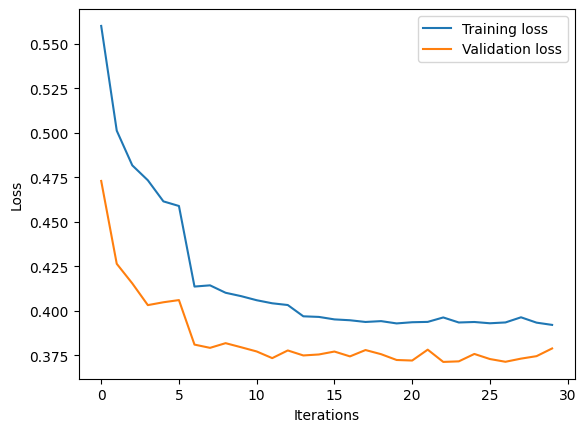

In [ ]:

train_losses_res_1 = np.load('/content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/train_losses_res_1_loader1.npy', allow_pickle=True)
val_losses_res_1 = np.load('/content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/val_losses_res_1_loader1.npy',allow_pickle=True)

plt.plot(train_losses_res_1, label='Training loss')
plt.plot(val_losses_res_1, label='Validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
# plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
plt.show()


In [ ]:
yresval, y_hatresval = val(valid_loader_color,base_model_1 , pretrained_criterion_1)

Val Loss: 0.371769

Val Accuracy: 85% (7282/8485)


In [ ]:
#yresval, y_hatresval = val(valid_loader_color,base_model_1 , pretrained_criterion_1)

In [ ]:
cmresnetval1 = confusion_matrix(yresval, y_hatresval)

<Figure size 640x480 with 0 Axes>

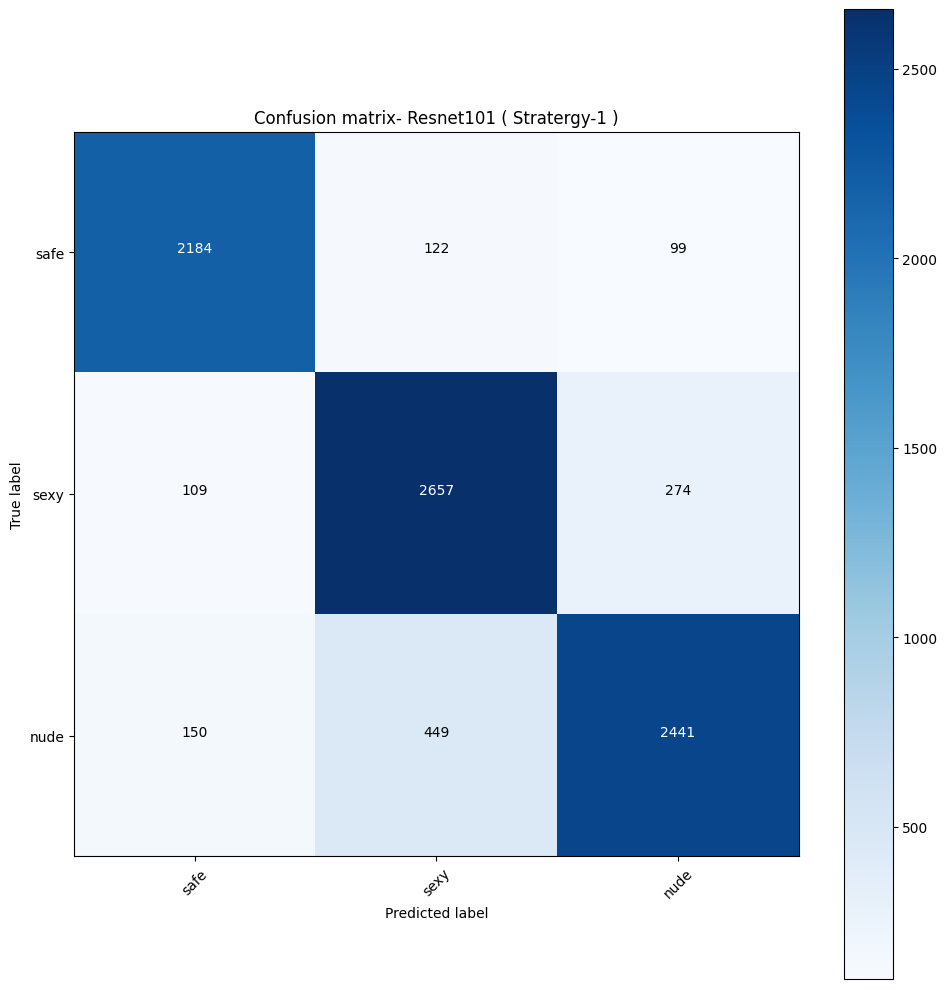

In [ ]:
plt.figure()
confusion_matrix2(cmresnetval1, classes=['safe','sexy','nude'],title='Confusion matrix- Resnet101 ( Stratergy-1 )',
                           filename='Confusion Matrix with Resnet101', figsize=(10,10))

In [ ]:
# Testing test data set over Resnet and images 224*224 stratery1
y, y_hat = test(test_loader_color,base_model_1 , pretrained_criterion_1)

Test Loss: 0.367452


Test Accuracy: 85% (18086/21212)


In [ ]:
cmresnet1 = confusion_matrix(y, y_hat)

<Figure size 640x480 with 0 Axes>

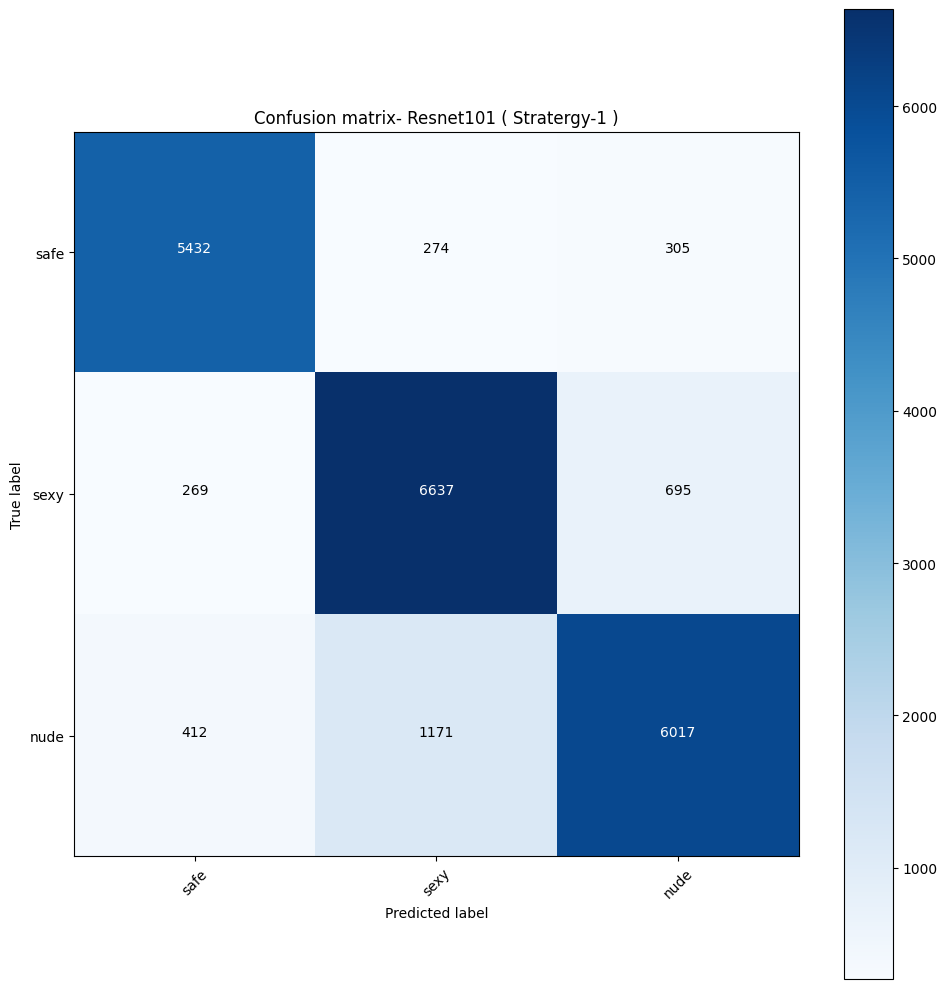

In [ ]:
plt.figure()
confusion_matrix2(cmresnet1, classes=['safe','sexy','nude']
                  ,title='Confusion matrix- Resnet101 ( Stratergy-1 )',
                           filename='Confusion Matrix with Resnet101', figsize=(10,10))

### Resnet101 [ Stratergy-2 : frezing previous layers and training only last few ]

In [113]:
pretrained_model_2 = models.resnet101(pretrained=True)
# pretrained_model_2 = models.vgg16(pretrained=True)

for param in pretrained_model_2.parameters():
    param.requires_grad = False

for param in pretrained_model_2.layer4.parameters():
    param.requires_grad = True

nb_features = pretrained_model_2.fc.in_features

pretrained_model_2.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
pretrained_model_2.to(device)
pretrained_model_2.fc

Sequential(
  (0): Linear(in_features=2048, out_features=1000, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1000, out_features=10, bias=True)
  (4): LogSoftmax(dim=1)
)

In [114]:
pretrained_criterion_2 = nn.CrossEntropyLoss()
params_2 = list(pretrained_model_2.fc.parameters()) + list(pretrained_model_2.layer4.parameters())
pretrained_optimizer_2 = torch.optim.Adam(params_2, lr=0.001)

In [115]:
from torch.optim import lr_scheduler
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_2 = lr_scheduler.StepLR(pretrained_optimizer_2, step_size=7, gamma=0.1)

In [116]:
base_model_2 = models.resnet101(pretrained=True)

# freezing all parameters
for param in base_model_2.parameters():
    param.requires_grad = False


for param in base_model_2.layer4.parameters():
    param.requires_grad = True

# nb_features = base_model_1.fc.in_features
# pretrained_model_1.to(device)

# changing last layer
base_model_2.fc = nn.Sequential(
    nn.Linear(2048, 1000),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1000, 10),
    nn.LogSoftmax(dim=1)
)
base_model_2.to(device)
# pretrained_model_1.fc

base_model_2.load_state_dict(torch.load('/content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/resnet_model_2_loader1_S2.pt'))


<All keys matched successfully>

In [ ]:
yres2val, y_hatres2val = val(valid_loader_color,base_model_2 , pretrained_criterion_2)

Val Loss: 0.697152

Val Accuracy: 91% (7723/8485)


In [ ]:
cmresnet2val = confusion_matrix(yres2val, y_hatres2val)

<Figure size 640x480 with 0 Axes>

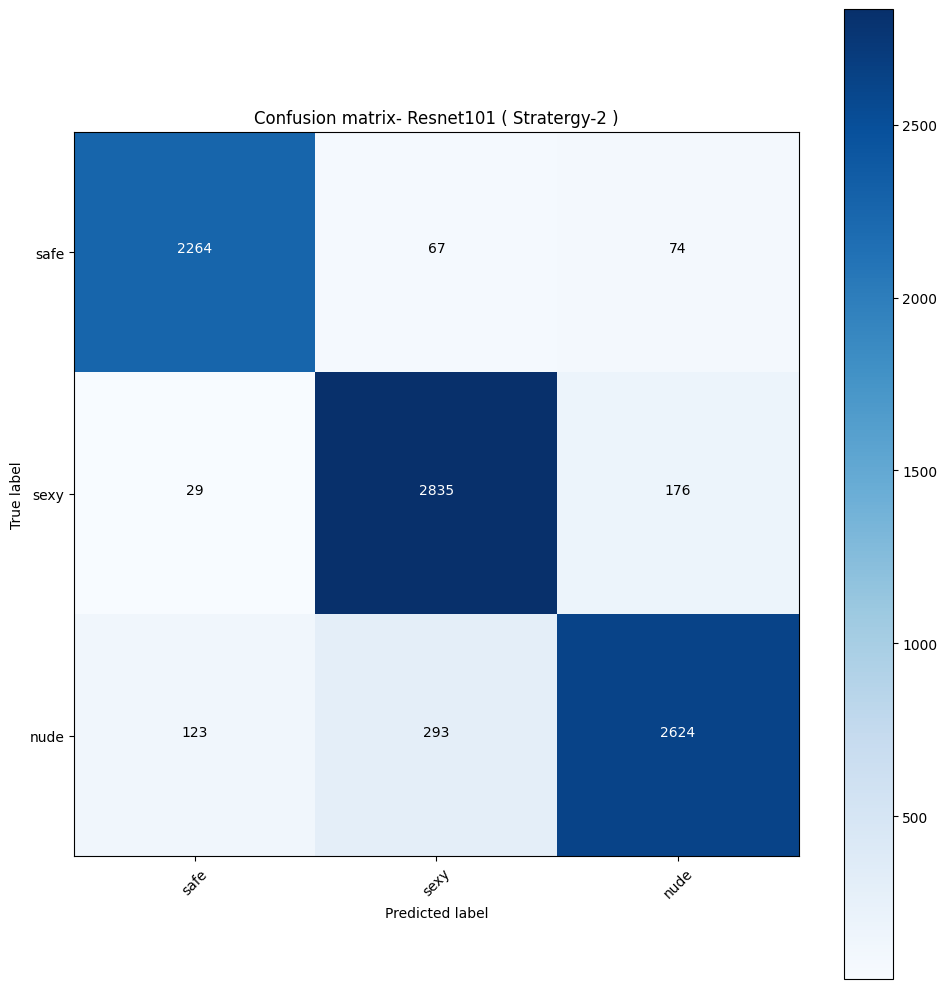

In [ ]:
plt.figure()
confusion_matrix2(cmresnet2val, classes=['safe','sexy','nude'],title='Confusion matrix- Resnet101 ( Stratergy-2 )',
                           filename='Confusion Matrix with CNN from scratch', figsize=(10,10))

In [ ]:
y, y_hat = test(test_loader_color,base_model_2 , pretrained_criterion_2)

Test Loss: 0.702704


Test Accuracy: 91% (19319/21212)


In [ ]:
cmresnet2 = confusion_matrix(y, y_hat)

In [ ]:
target_names =['safe','sexy','nude']
report=classification_report(y, y_hat, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('resnet2testreport.csv')
print(classification_report(y, y_hat, target_names=target_names))

              precision    recall  f1-score   support

        safe       0.94      0.94      0.94      6011
        sexy       0.89      0.93      0.91      7601
        nude       0.91      0.87      0.89      7600

    accuracy                           0.91     21212
   macro avg       0.91      0.91      0.91     21212
weighted avg       0.91      0.91      0.91     21212



<Figure size 640x480 with 0 Axes>

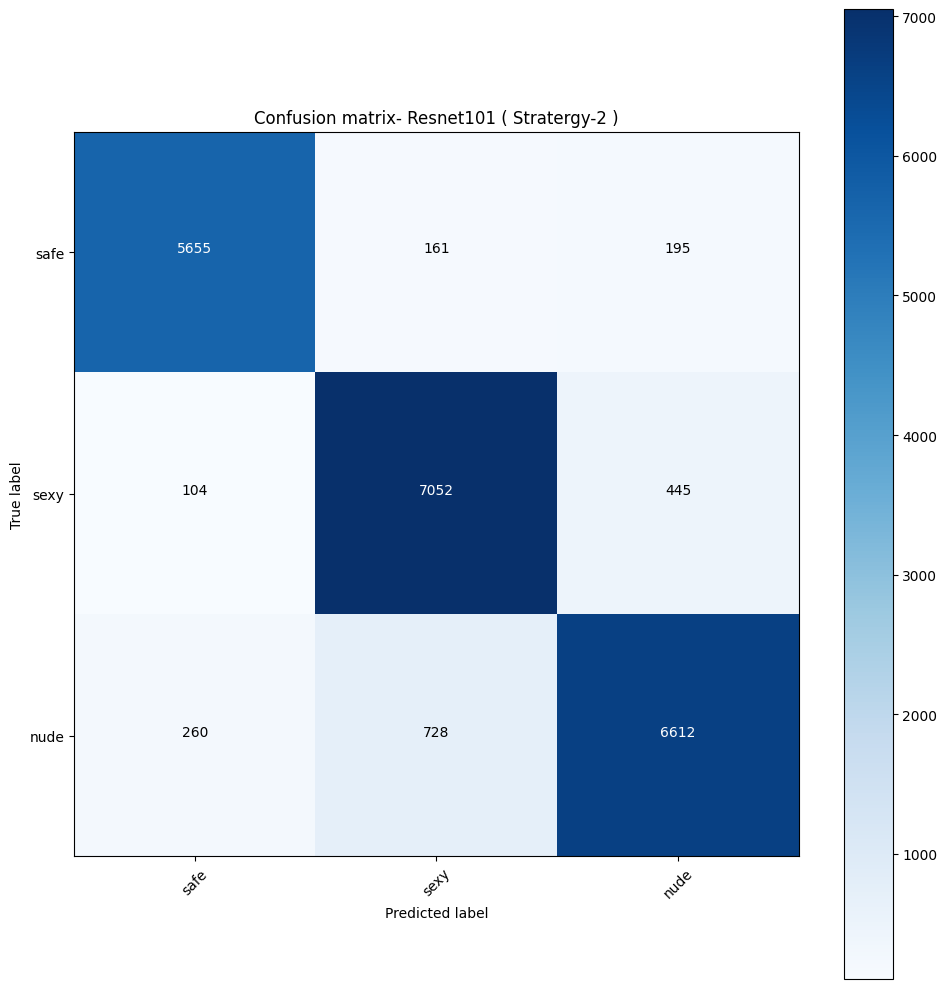

In [ ]:
plt.figure()
confusion_matrix2(cmresnet2, classes=['safe','sexy','nude'] ,title='Confusion matrix- Resnet101 ( Stratergy-2 )', filename='Confusion Matrix with CNN from scratch', figsize=(10,10))

### Class Activation Map over resnet

In [167]:
def display_class_activation_mapping(img , base_model, ax=None):

  class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

  def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

  # CODE TO PREPROCESS IMAGE
  normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
  )

  # Preprocessing - scale to 224x224 for model, convert to tensor,
  # and normalize to -1..1 with mean/std for ImageNet

  preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
  ])

  display_transform = transforms.Compose([
    transforms.Resize((224,224))])

  img = Image.fromarray(img).convert('RGB')
  tensor = preprocess(img)
  prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
  plt.imshow(img)

  # PREDICTION USING MODEL
  base_model.cuda()
  base_model.eval()


  # save features of final layer
  final_layer = base_model._modules.get('layer4')

  activated_features = SaveFeatures(final_layer)

  prediction = base_model(prediction_var)

  activated_features.remove()

  weight_softmax_params = list(base_model._modules.get('fc').parameters())
  weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

  # predicted class
  class_idx = topk(prediction,1)[1].int()
  arr = ['safe','sexy','nude']
  # print(arr[class_idx])

  overlay = getCAM(activated_features.features, weight_softmax, class_idx )

  display_transform = transforms.Compose([
    transforms.Resize((224,224))])

  if ax is None:
    plt.imshow(display_transform(img))
    plt.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');
  else:
    ax.imshow(display_transform(img))
    ax.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet');

  return arr[class_idx]



In [168]:
# Displaying some train images
temp = [20,200,300,400,700,150,900,1000,110,950,10,500,600,350,765,733,699,777,11,244,632,33,93,40,76]
fig, axs = plt.subplots(5,5, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
j = 0
for i, ax in enumerate(axs.ravel()):
  t = display_class_activation_mapping(val_imgs_color[temp[j]] , base_model_2,ax)
  ax.title.set_text(t)
  j = j+1

Output hidden; open in https://colab.research.google.com to view.

### CNN Using Gray

In [12]:
def CreateCNNModel(img_rows,img_cols,channels):
  model = Sequential()
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(img_rows,img_cols,channels)))
  model.add(BatchNormalization())
  model.add(Conv2D(32,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.3))
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization())
  model.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
  model.add(BatchNormalization(axis = 3))
  model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(units = 512,activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(units = 128,activation='relu'))
  model.add(Dropout(0.25))
  model.add(Dense(3,activation='softmax'))
  model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')
  return model

In [40]:
modelGo=CreateCNNModel(224,224,1)
import pickle
pickle.dump(modelGo, open(modelfolderpath+'modelGo.pkl', 'wb'))

In [14]:
filepath        = '/content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/gray_vg16_new_full.hdf5'
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [16]:
y_hat_val=modelGo.predict(val_imgs)
y_hat_val=np.argmax(y_hat_val,axis=1)
metrics.accuracy_score(val_y, y_hat_val)

266/266 [==============================] - 9s 34ms/step


0.9767825574543312

In [17]:
cmcnnvalcolor = confusion_matrix(val_y, y_hat_val)

In [18]:
target_names =['safe','sexy','nude']
report=classification_report(val_y, y_hat_val, target_names=target_names,output_dict=True)
df = pd.DataFrame(report).transpose()
#df.to_csv('vggvalreport.csv')

print(classification_report(val_y, y_hat_val, target_names=target_names))

              precision    recall  f1-score   support

        safe       0.98      0.97      0.98      2405
        sexy       0.98      0.98      0.98      3040
        nude       0.97      0.98      0.97      3040

    accuracy                           0.98      8485
   macro avg       0.98      0.98      0.98      8485
weighted avg       0.98      0.98      0.98      8485



<Figure size 640x480 with 0 Axes>

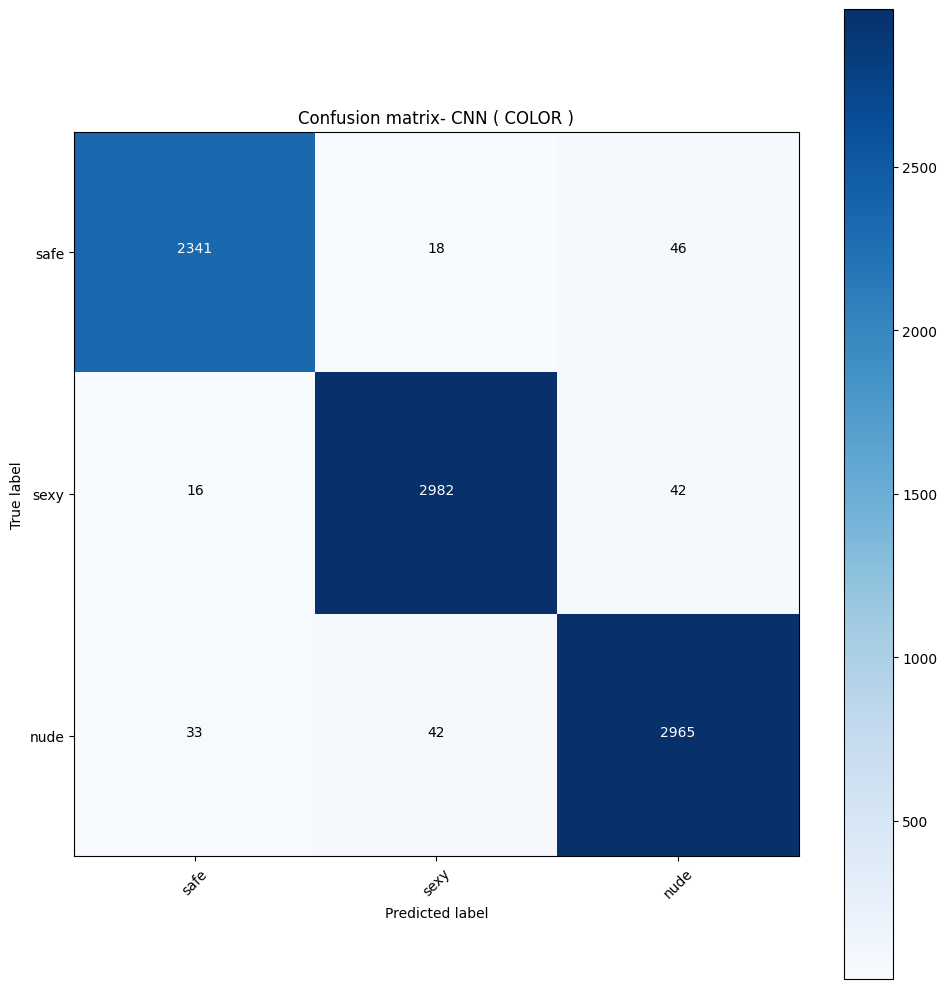

In [21]:
plt.figure()
confusion_matrix2(cmcnnvalcolor, classes=['safe','sexy','nude'],title='Confusion matrix- CNN ( COLOR )', filename='Confusion Matrix with CNN from scratch with Gray Images', figsize=(10,10))

### Predection ResNet

In [162]:
def Predit(test_loaders, model, criterion):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None

    model.eval()
    for batch_idx, (data, target) in enumerate(test_loaders):
        # move to GPU or CPU
        data, target = data.to(device), target.to(device)

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())

        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    #print('Test Loss: {:.6f}\n'.format(test_loss))

    #print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        #100. * correct / total, correct, total))

    return y, y_hat

In [117]:
def load_color_resize_image(path, rows=224, cols=224):
    img = cv2.imread(path)
    img_resize_color = cv2.resize(img,(rows,cols))
    return img_resize_color

In [165]:
Imagepath_files = os.listdir("/content/gdrive/MyDrive/Community Help /Abuse Image classification/PredictImages/")
for item in Imagepath_files:

  if item !=".ipynb_checkpoints":
    print("Image Name : ",item)
    img_resize_color=load_color_resize_image("/content/gdrive/MyDrive/Community Help /Abuse Image classification/PredictImages/"+item)
    print('img_resize_color.shape : ',img_resize_color.shape)

    img_resize_color=img_resize_color.reshape(-1,224,224,3)
    print('Reshape img_resize_color.shape : ',img_resize_color.shape)

    yy=[2]

    test_dataset2_color_pre = MyDataset(img_resize_color,np.array(yy),data_transforms2['test'])
    test_loader2_color_pre = DataLoader(test_dataset2_color_pre, batch_size=32, shuffle=False)
    y, y_hat = Predit(test_loader2_color_pre,base_model_1 , pretrained_criterion_1)
    print('base_model_1 : y_hat : ',y_hat)
    #print("------------------------------")
    y, y_hat2 = Predit(test_loader2_color_pre,base_model_2 , pretrained_criterion_1)
    print('base_model_2 : y_hat2 : ',y_hat2)
    print("----------------------------------------------")

Image Name :  1.jpg
img_resize_color.shape :  (224, 224, 3)
Reshape img_resize_color.shape :  (1, 224, 224, 3)
base_model_1 : y_hat :  [1]
base_model_2 : y_hat2 :  [0]
----------------------------------------------
Image Name :  2.jpg
img_resize_color.shape :  (224, 224, 3)
Reshape img_resize_color.shape :  (1, 224, 224, 3)
base_model_1 : y_hat :  [1]
base_model_2 : y_hat2 :  [2]
----------------------------------------------
Image Name :  3.jpg
img_resize_color.shape :  (224, 224, 3)
Reshape img_resize_color.shape :  (1, 224, 224, 3)
base_model_1 : y_hat :  [1]
base_model_2 : y_hat2 :  [2]
----------------------------------------------
Image Name :  4.jpg
img_resize_color.shape :  (224, 224, 3)
Reshape img_resize_color.shape :  (1, 224, 224, 3)
base_model_1 : y_hat :  [0]
base_model_2 : y_hat2 :  [0]
----------------------------------------------
Image Name :  Nude.jpg
img_resize_color.shape :  (224, 224, 3)
Reshape img_resize_color.shape :  (1, 224, 224, 3)
base_model_1 : y_hat :  [2

### Predection VGG

In [ ]:
import pickle
modelGo = pickle.load(open('modelGo.pkl', 'rb'))
filepath        = '/content/gdrive/MyDrive/Community Help /Abuse Image classification/Models/gray_vg16_new_full.hdf5'
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [42]:
def load_gray_resize_image(path, rows=224, cols=224, gray=True):
    img = cv2.imread(path,0)
    img_resize_gray = cv2.resize(img,(rows,cols))
    return img_resize_gray

In [96]:
img_resize_gray=load_gray_resize_image("/content/gdrive/MyDrive/Community Help /Abuse Image classification/PredictImages/Sex.jpg")

In [97]:
img_resize_gray=img_resize_gray.reshape(1,224,224,1)
img_resize_gray.shape

(1, 224, 224, 1)

In [98]:
y_hat_pred=modelGo.predict(img_resize_gray)
y_hat_pred=np.argmax(y_hat_pred,axis=1)
y_hat_pred

1/1 [==============================] - 0s 18ms/step


array([2])